

References:

1. https://medium.com/@chenycy/unlock-price-optimization-potential-with-python-modelling-linear-and-non-linear-price-elasticity-563773e5ba53

2. https://www.youtube.com/watch?v=fpZC_tEfnLM (How to add Extra Regression Variables a.k.a instrumental variable for support, example supply, freight...).

In [1]:
import os
import boto3
import awswrangler
import numpy as np
import pandas as pd
import statsmodels.api as sm
from datetime import timedelta, datetime
from matplotlib import pyplot as plt 

#### Aux Functions

In [7]:
def read_data(
    date: str,
    product_id: str | bool = None
) -> pd.DataFrame:
    product_id = f" AND i.idProduto = '{product_id}' " if product_id else ""

    query = f"""
    WITH filter_months AS ( 
        SELECT 
            i.idProduto, 
            date(p.dtPedido) AS dtPedido,
            MAX(i.vlPreco) AS vlPreco,
            COUNT(*) AS demanda
        FROM item_pedido i 
        LEFT JOIN pedido p ON i.idPedido = p.idPedido 
        WHERE p.dtPedido <= '{date}'  {product_id}
        GROUP BY i.idProduto, date(p.dtPedido)
    ),
    filter_products AS (
        SELECT 
            idProduto,
            COUNT(*) AS qtd
        FROM filter_months
        GROUP BY 1
        HAVING qtd >= 50
    )
    SELECT 
        f.idProduto,
        f.dtPedido,
        f.vlPreco,
        f.demanda
    FROM filter_months f
    -- INNER JOIN filter_products p ON p.idProduto = f.idProduto
    ORDER BY 1, 2
    """

    session = boto3.Session(
        aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
        aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
        region_name="us-east-1"
    )

    return awswrangler.athena.read_sql_query(
        query,
        database="ols_lh_trusted",
        boto3_session=session
    )


def fit_ols(
    demand: pd.Series,
    price: pd.Series,
    extra_plots: bool = True,
    print_summary: bool = True,
    return_demand_price_fig: bool = False
):
    
    # Fit OLS Model
    x_price = sm.add_constant(price)
    lr = sm.OLS(demand, x_price).fit()

    if print_summary:
        print(lr.summary())

    # Generate Extra Figures
    if extra_plots:
        fig, ax = plt.subplots(1, 2, figsize=(15, 4))
        ax = ax.flatten()

        ax[0].set_title("Price & Demand Histogram")
        ax[0].hist(price, bins=10, histtype="step", label="price")
        ax[0].hist(demand, bins=10, histtype="step", label="demand")

        ax[1].set_title("Price x Demand")
        ax[1].scatter(x=demand, y=price)
        ax[1].set_xlabel("demand")
        ax[1].set_ylabel("price")

        for axi in ax:
            axi.legend()
            axi.grid(2)

        fig = plt.figure(figsize=(10,5))
        sm.graphics.plot_regress_exog(lr, "vlPreco", fig=fig)
        fig.tight_layout(pad=1.0);

        min_max_price = np.array([min(price), max(price)])
        predictions = np.exp(lr.predict(sm.add_constant(min_max_price)))
        min_max_price = np.exp(min_max_price)

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(np.exp(price), np.exp(demand))
        ax.plot(min_max_price, predictions, "k--")
        ax.set_xlabel("Price")
        ax.set_ylabel("Demand");
        ax.set_title(datetime.now())
        ax.grid(2)

        return lr, fig
    
    if return_demand_price_fig:
        min_max_price = np.array([min(price), max(price)])
        predictions = np.exp(lr.predict(sm.add_constant(min_max_price)))
        min_max_price = np.exp(min_max_price)

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(np.exp(price), np.exp(demand))
        ax.plot(min_max_price, predictions, "k--")
        ax.set_xlabel("Price")
        ax.set_ylabel("Demand");
        ax.set_title(datetime.now())
        ax.grid(2)

        return lr, fig

    else:
        return lr

#### EDA

In [3]:
query = f"""
WITH filter_months AS ( 
SELECT 
		i.product_id, 
		date(p.order_purchase_timestamp) AS dtPedido,
		MAX(i.price) AS vlPreco,
		COUNT(*) AS demanda
	FROM oltp_prod_order_item i 
	LEFT JOIN oltp_prod_order p ON i.order_id = p.order_id
	WHERE p.order_purchase_timestamp <= DATE('2018-01-01')
	GROUP BY i.product_id, date(p.order_purchase_timestamp)
),
filter_products AS (
	SELECT 
		product_id,
		COUNT(*) AS qtd
	FROM filter_months
	GROUP BY 1
	HAVING count(*) >= 50
)
SELECT 
	f.product_id,
	f.dtPedido,
	f.vlPreco,
	f.demanda
FROM filter_months f
ORDER BY 1, 2
"""

session = boto3.Session(
	aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
	aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
	region_name="us-east-1"
)

df = awswrangler.athena.read_sql_query(
	query,
	database="ols_lh_trusted",
	boto3_session=session
)

/tmp/ipykernel_36631/3854894738.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))


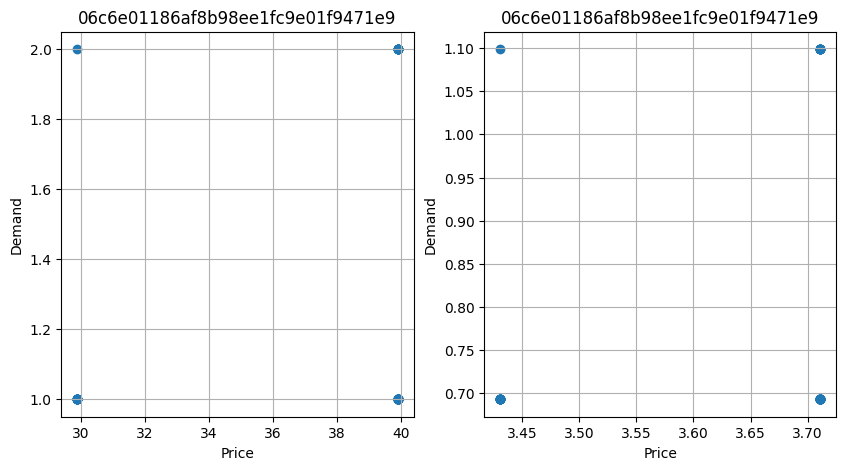

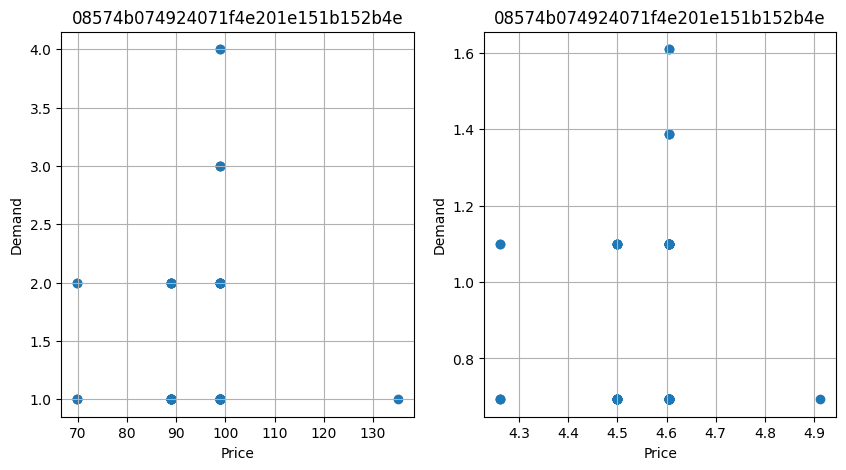

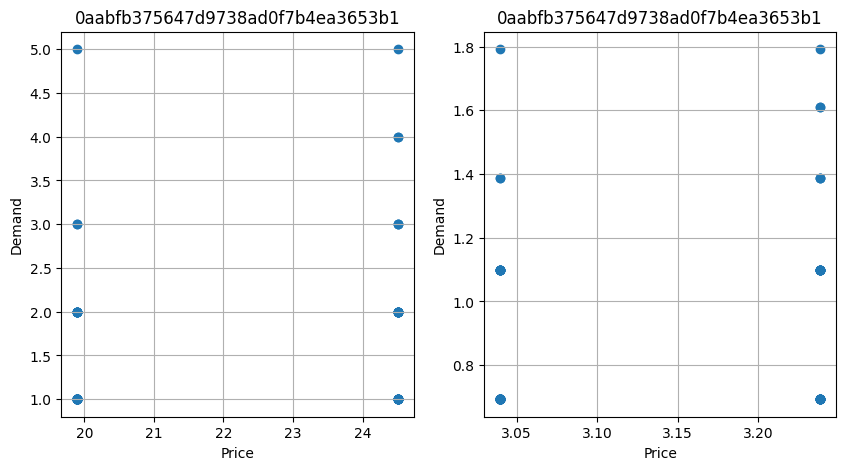

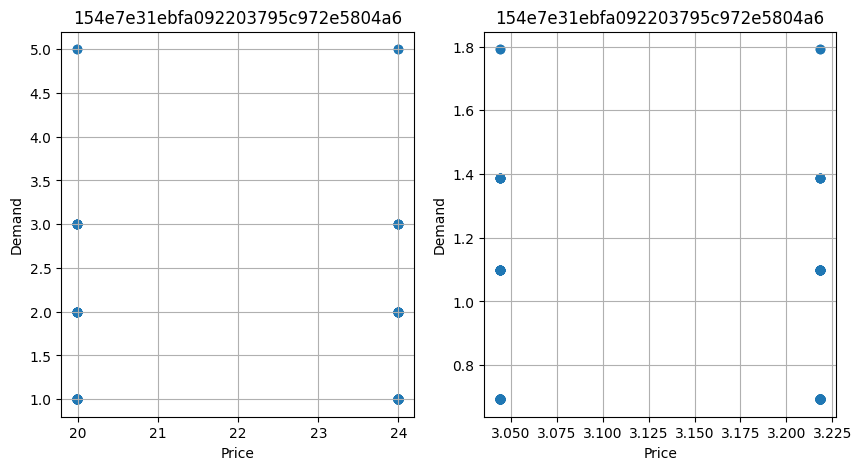

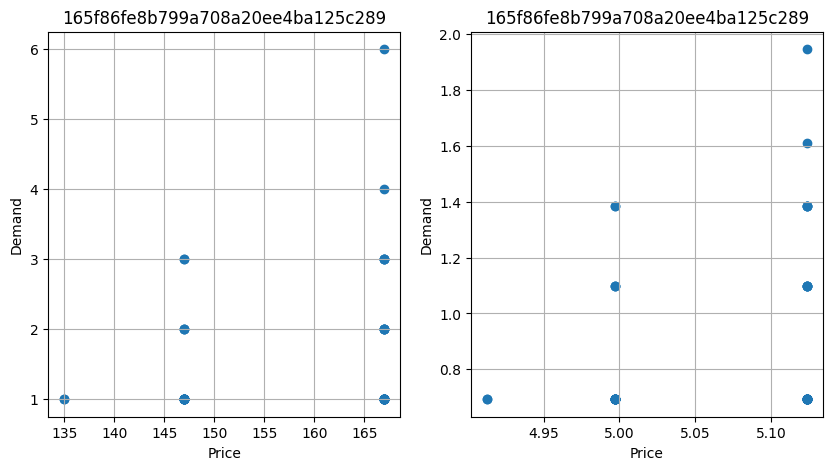

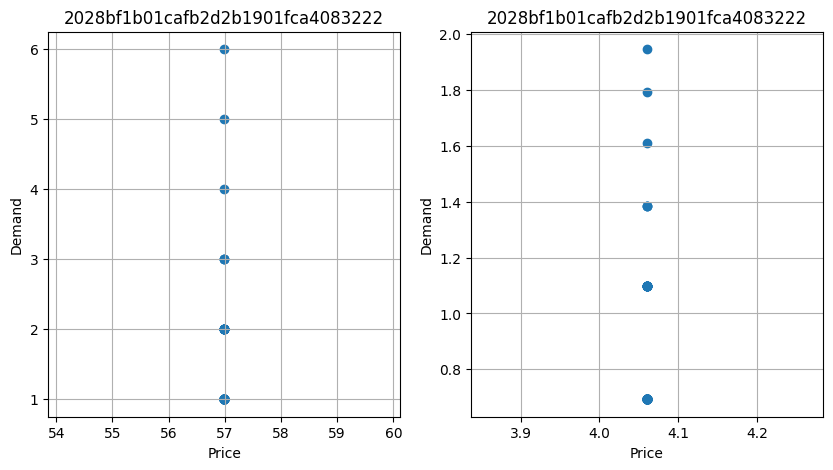

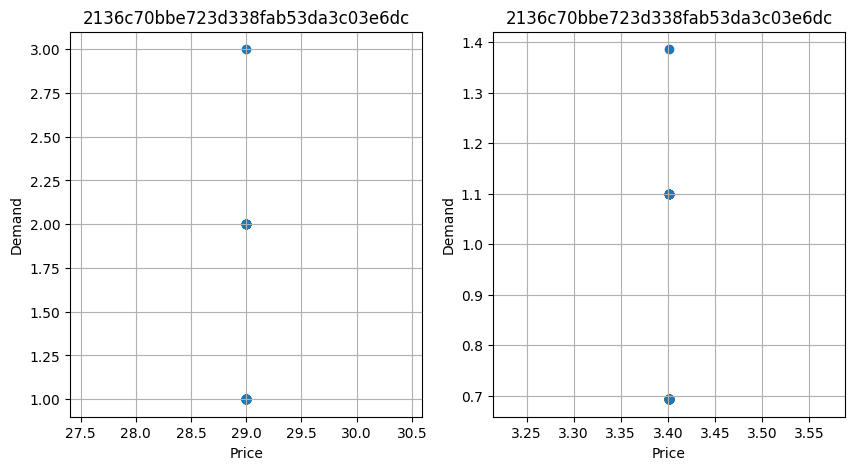

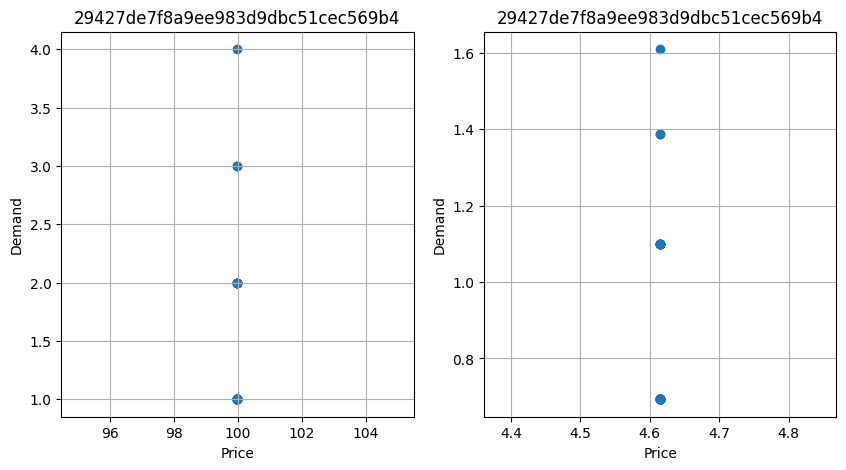

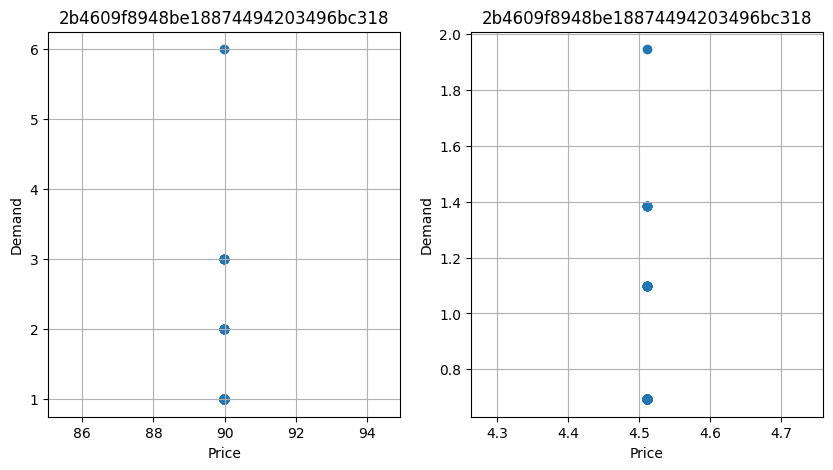

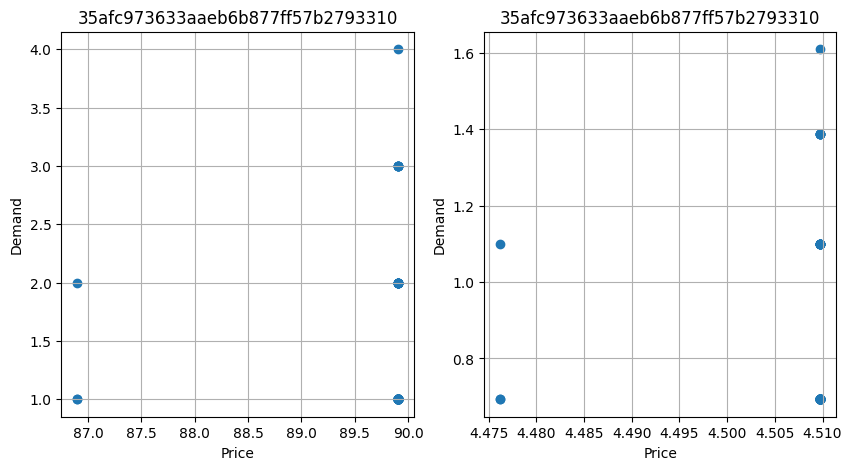

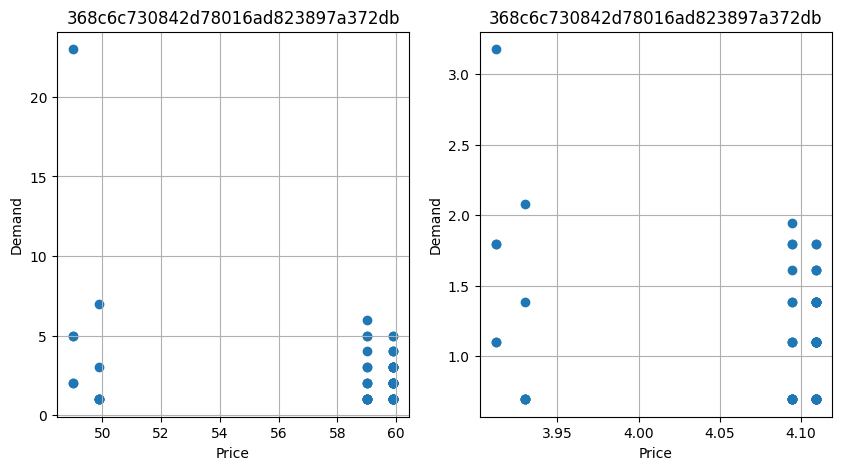

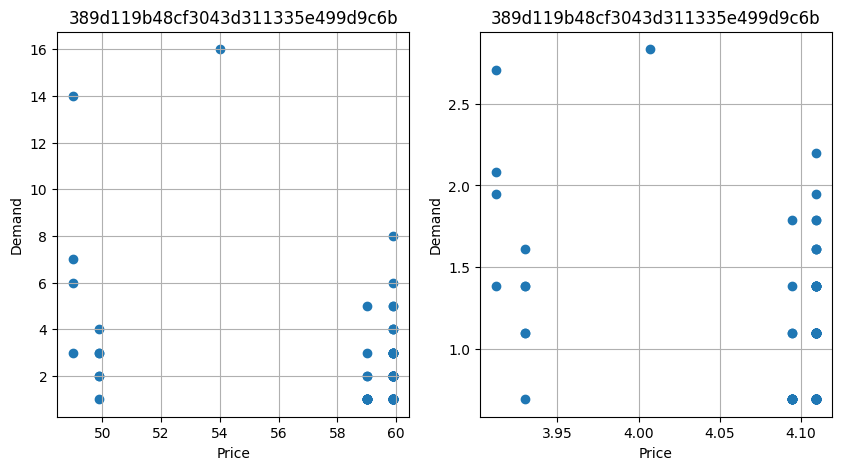

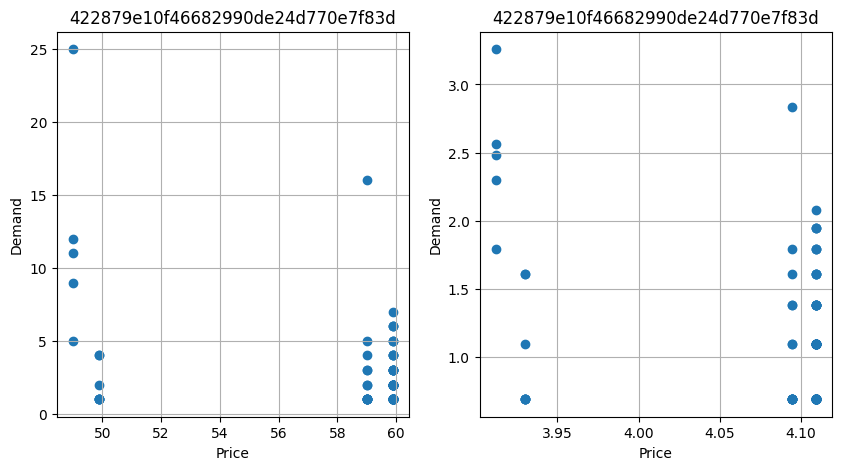

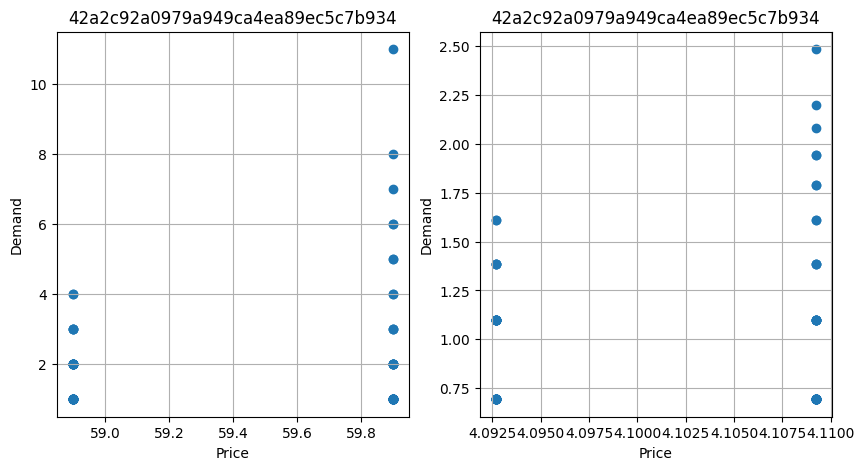

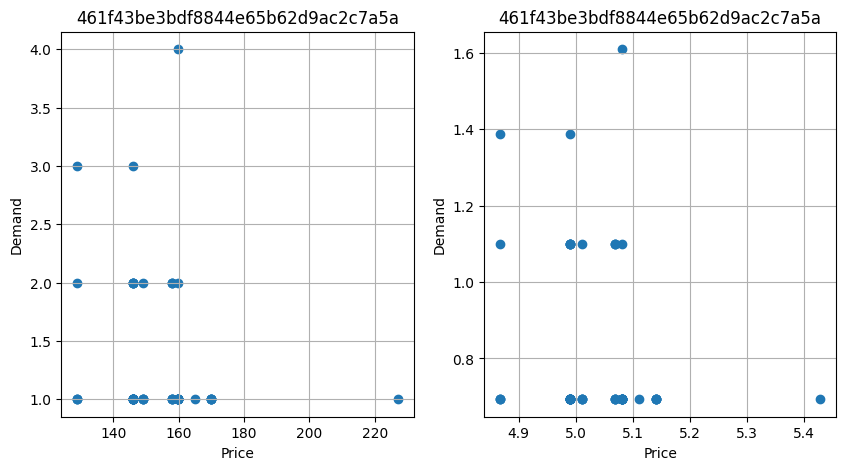

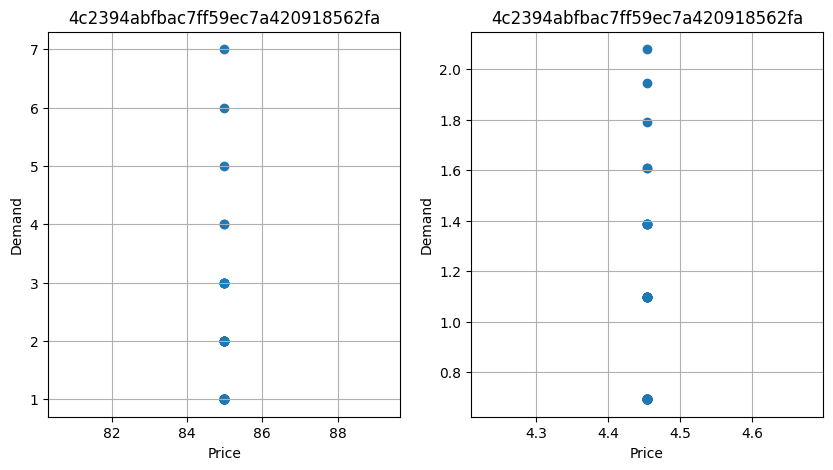

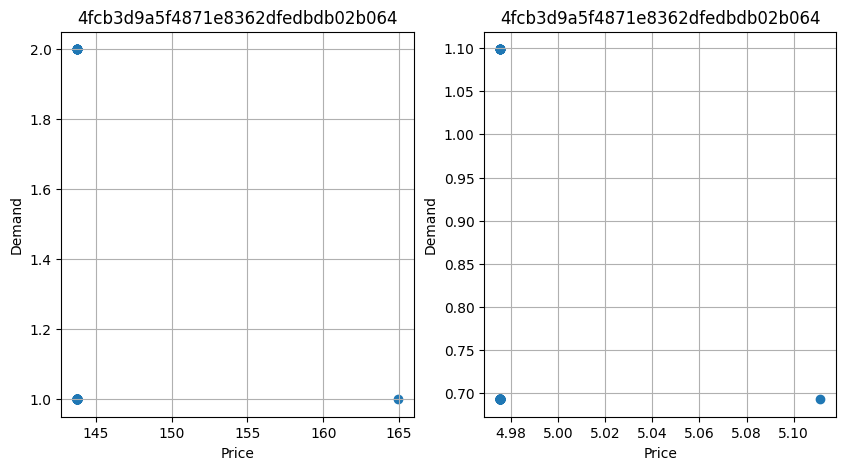

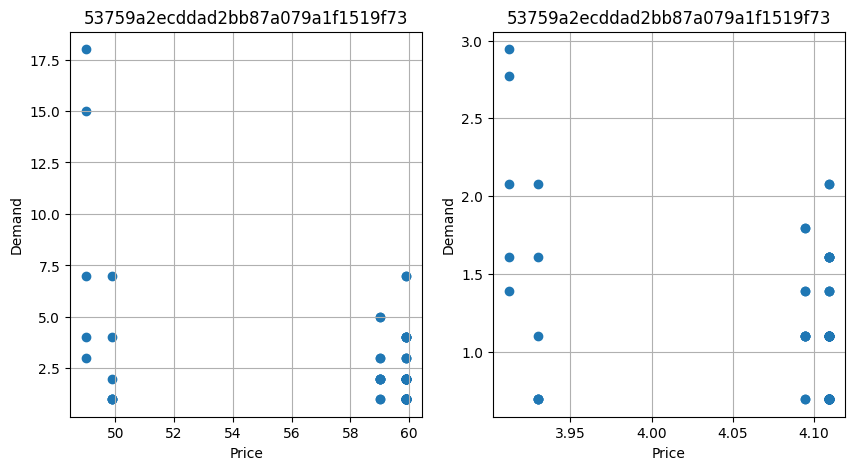

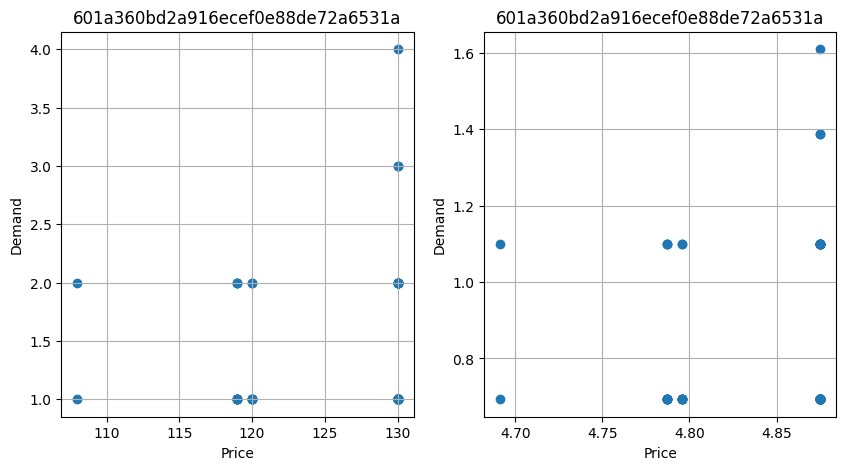

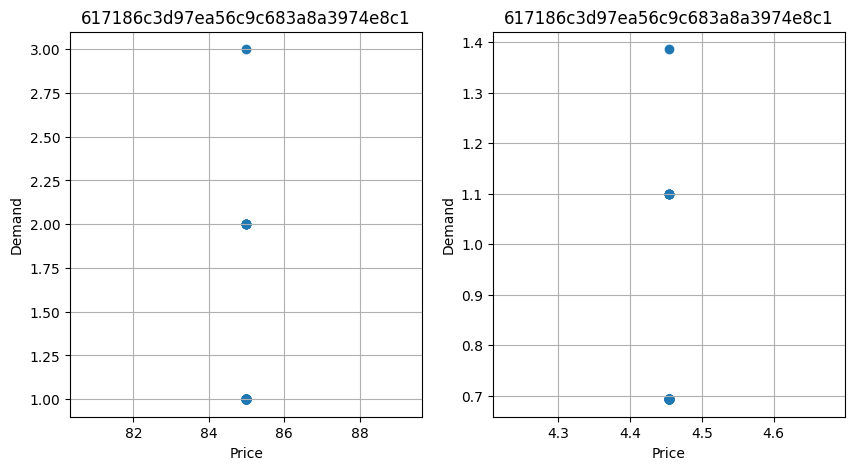

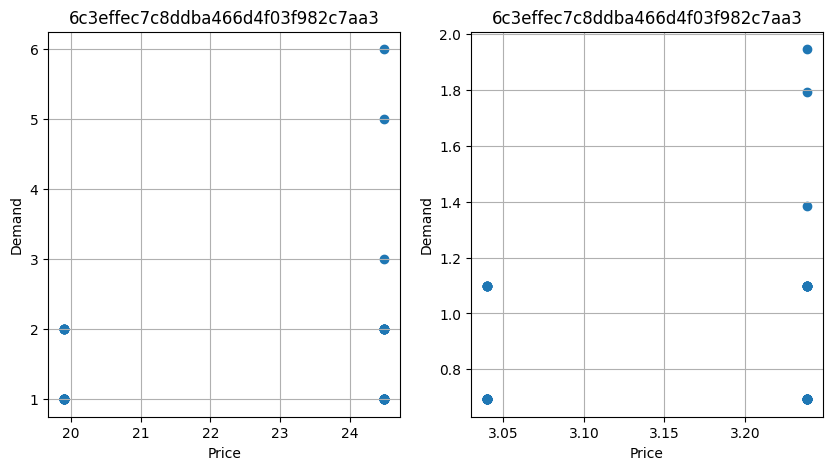

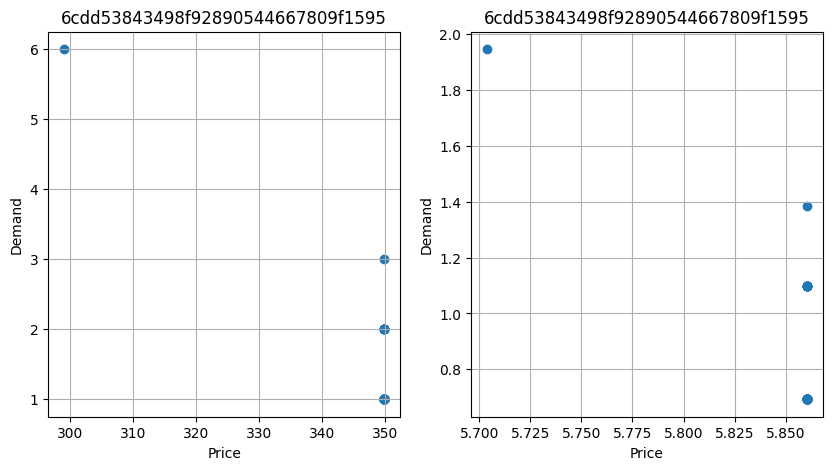

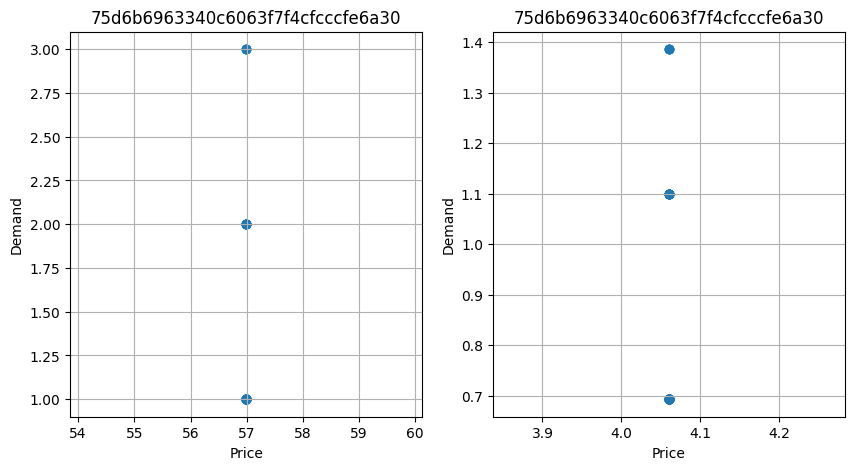

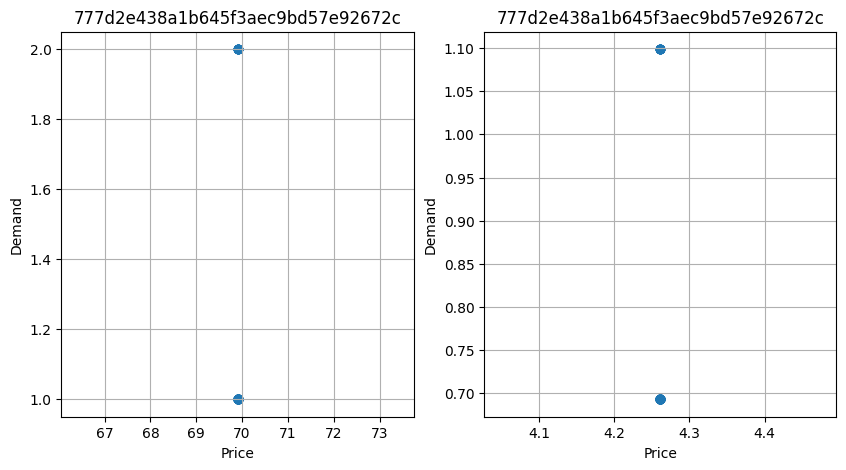

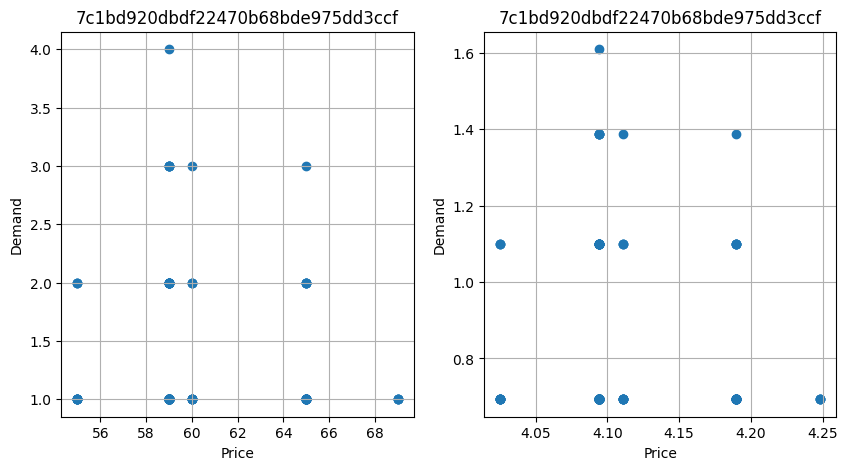

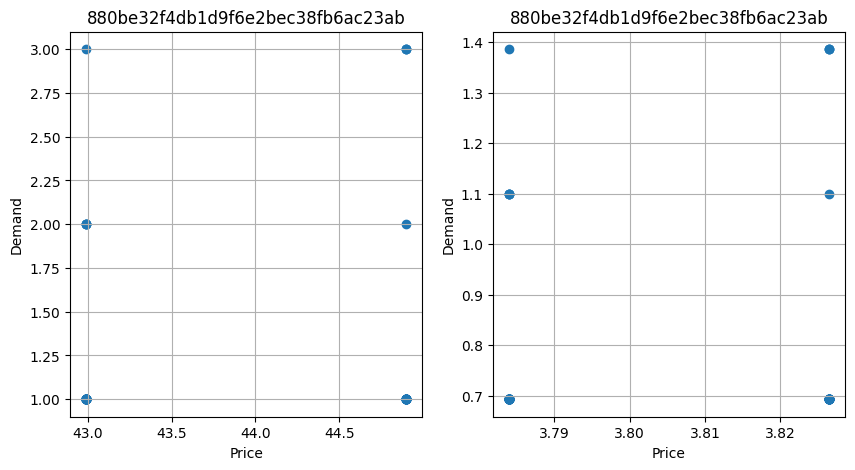

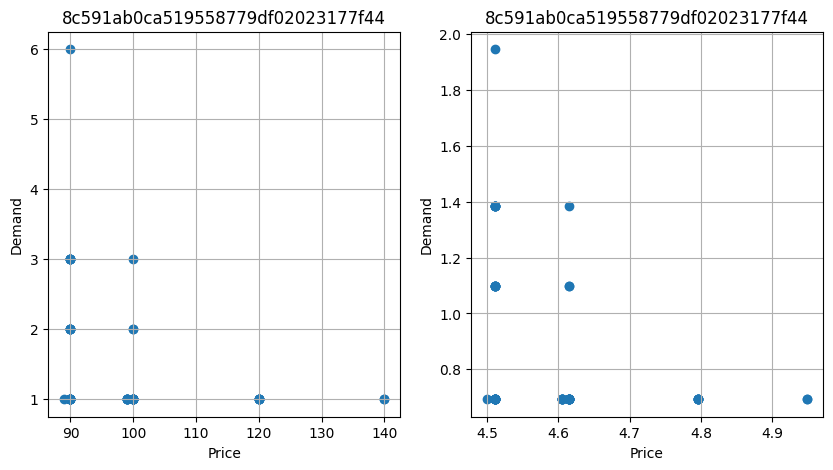

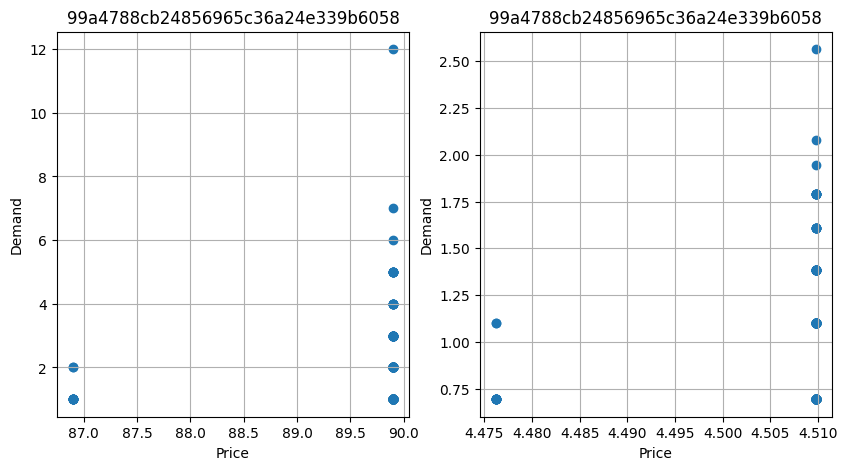

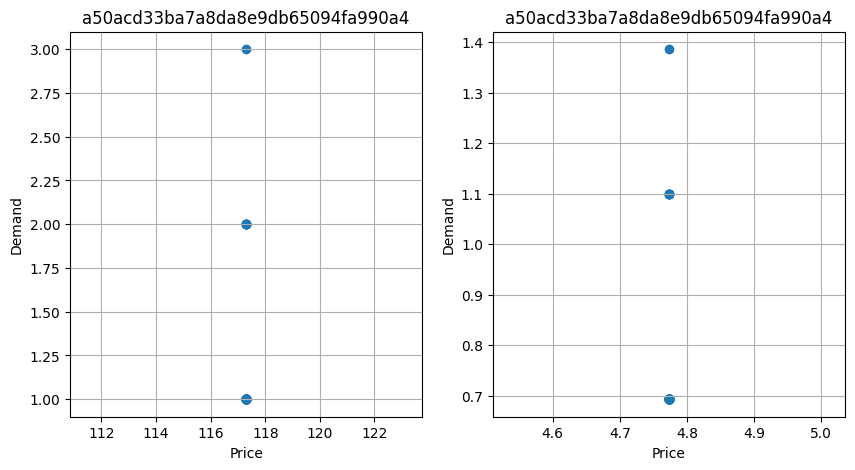

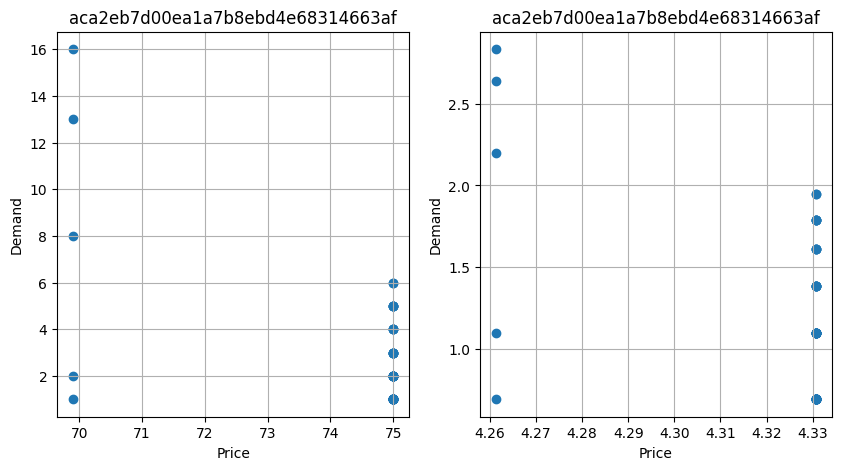

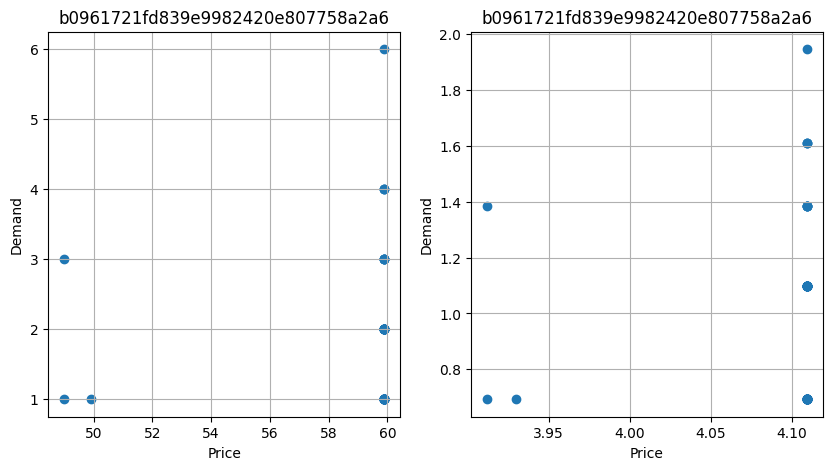

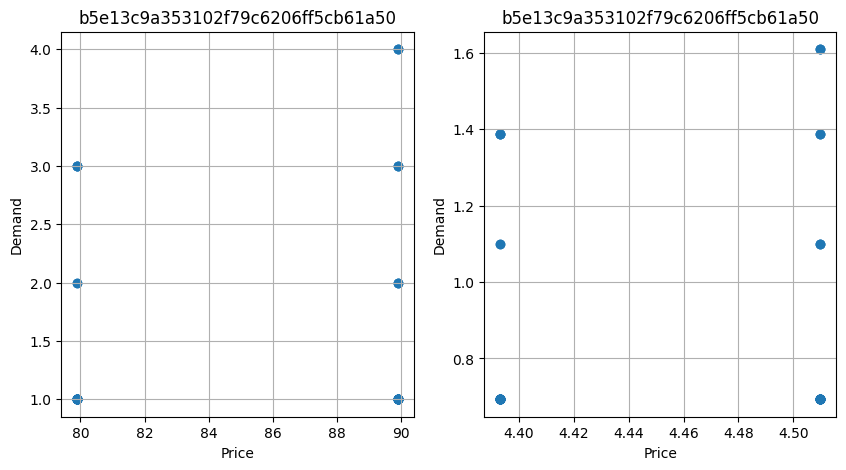

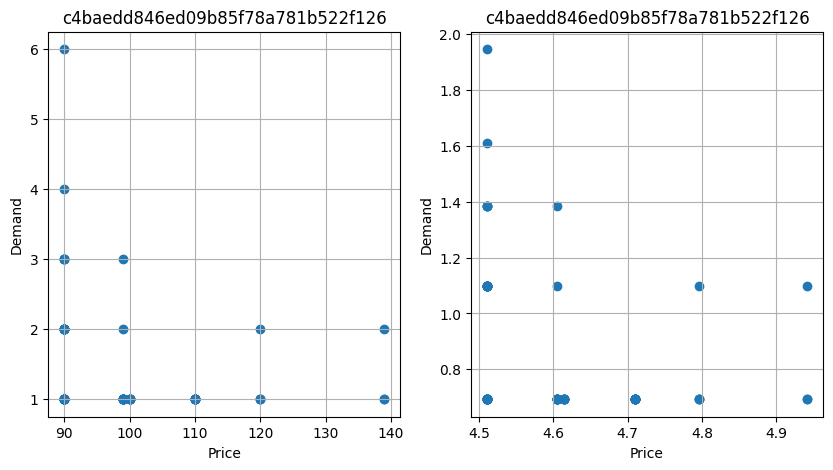

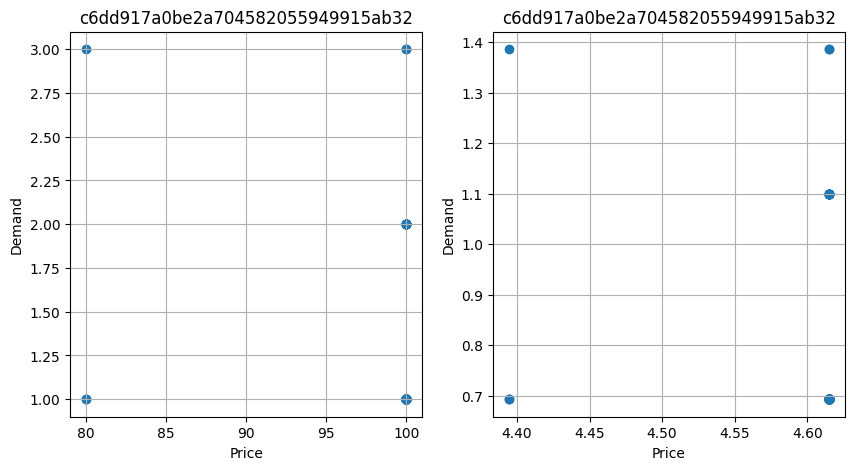

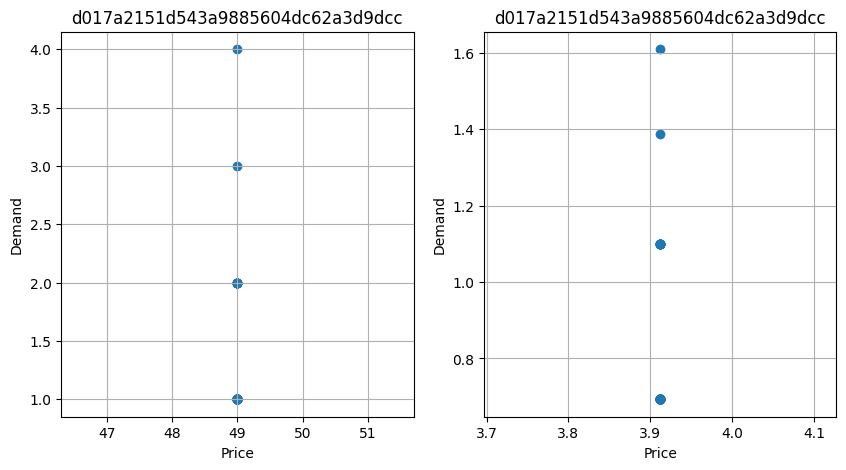

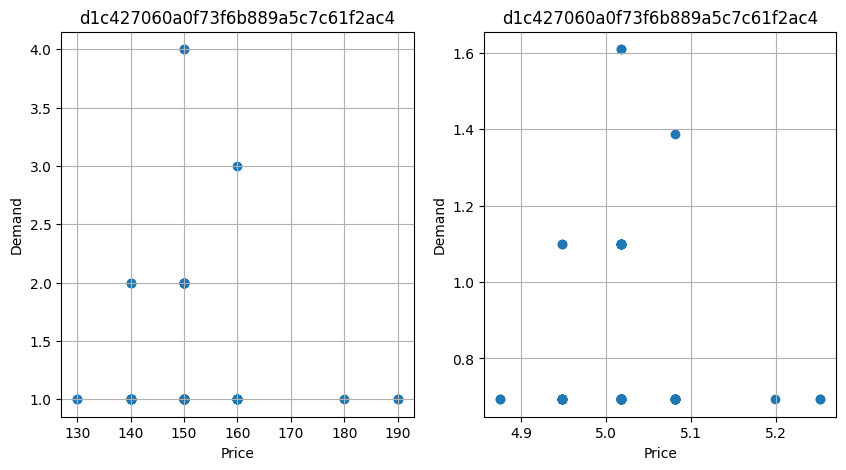

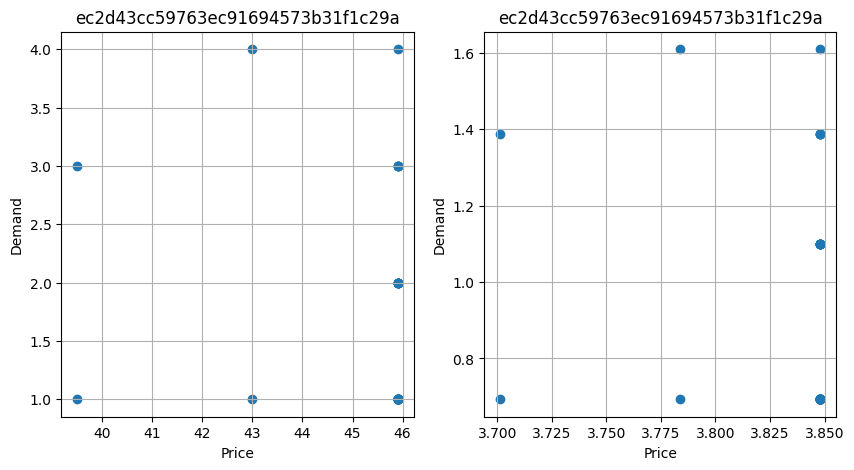

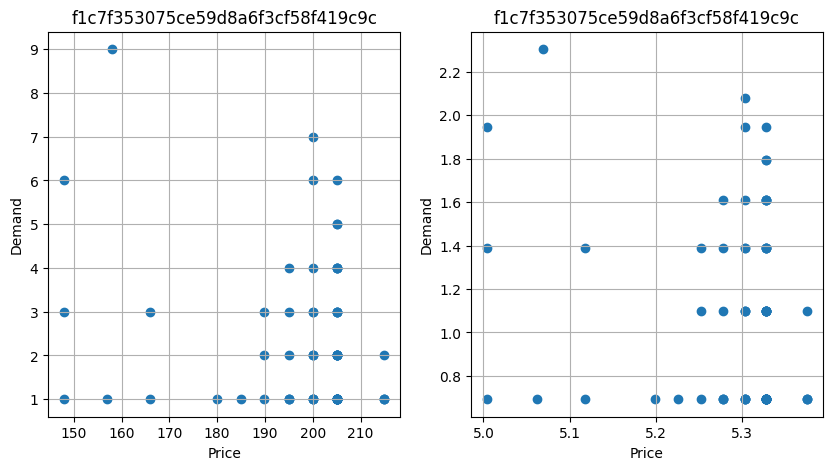

In [4]:
for product in df["idProduto"].unique():
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax = ax.flatten()

    ax[0].set_title(product)
    ax[0].grid(2)
    ax[0].scatter(
        df.loc[df["idProduto"] == product, "vlPreco"],
        df.loc[df["idProduto"] == product, "demanda"]
    )
    ax[0].set_ylabel("Demand")
    ax[0].set_xlabel("Price")

    ax[1].set_title(product)
    ax[1].grid(2)
    ax[1].scatter(
        np.log1p(df.loc[df["idProduto"] == product, "vlPreco"]),
        np.log1p(df.loc[df["idProduto"] == product, "demanda"])
    )
    ax[1].set_ylabel("Demand")
    ax[1].set_xlabel("Price")

In [18]:
df.loc[df["idProduto"] == "8c591ab0ca519558779df02023177f44", "vlPreco"].describe()

count     52.000000
mean      98.895768
std       12.575732
min       89.000000
25%       89.989998
50%       99.000000
75%       99.989998
max      139.990005
Name: vlPreco, dtype: float64

#### Price Elasticity

##### Product: 8c591ab0ca519558779df02023177f44

For product "8c591ab0ca519558779df02023177f44", if the price increase 10%, the demand decrease by 9.4 %

                            OLS Regression Results                            
Dep. Variable:                demanda   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     7.960
Date:                Fri, 20 Dec 2024   Prob (F-statistic):            0.00684
Time:                        17:45:04   Log-Likelihood:                -6.7025
No. Observations:                  52   AIC:                             17.41
Df Residuals:                      50   BIC:                             21.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2980      1.569      3.377      0.0

/tmp/ipykernel_6050/4012652754.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axi.legend()


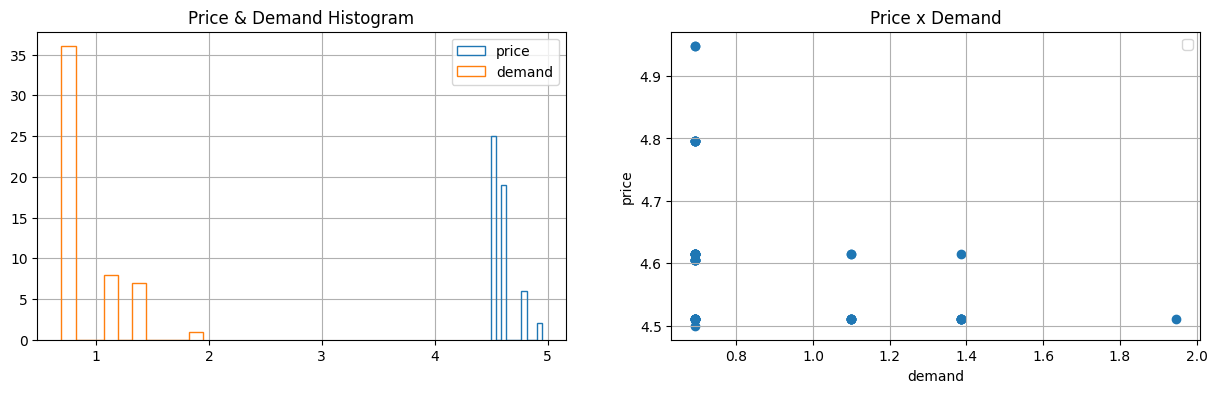

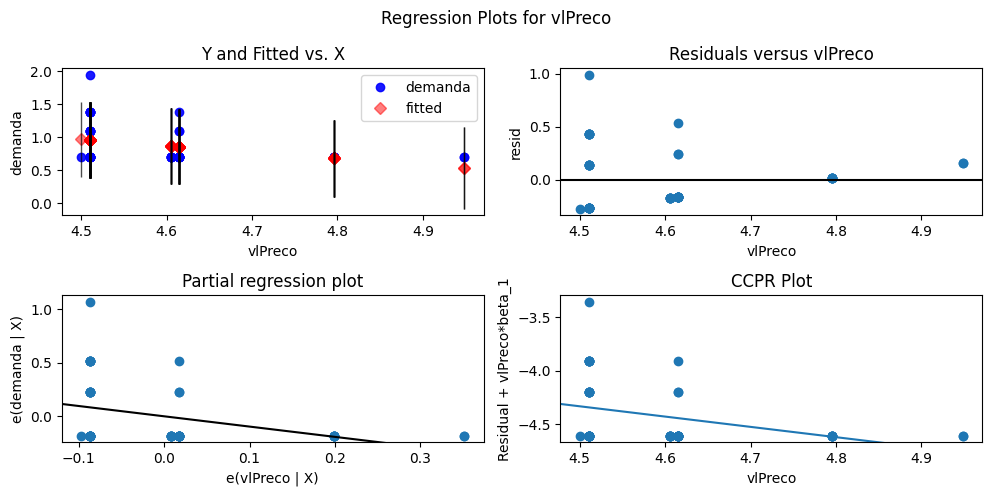

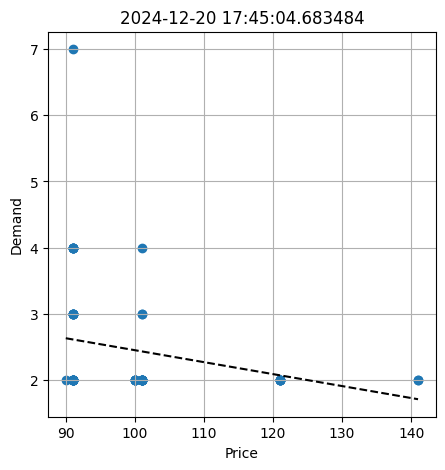

In [19]:
demand = np.log1p(df.loc[df["idProduto"] == "8c591ab0ca519558779df02023177f44", "demanda"])
price  = np.log1p(df.loc[df["idProduto"] == "8c591ab0ca519558779df02023177f44", "vlPreco"])

lr, fig = fit_ols(
    demand,
    price
)

In [70]:
pvalue = lr.f_pvalue
intercept, slope = lr.params

elasticity = slope

print("Price Elasticity {} with pvalue {}".format(elasticity, pvalue))

Price Elasticity -1.238430161490157 with pvalue 0.006740792201101126


In [57]:
prices = list(range(50, 200, 10))

for price in prices:
    new_demand = np.round(np.exp(lr.predict([1, np.log1p(price)]))[0], 3)
    print(f"Given a price of: {price}, the demand is: {new_demand}.")

Given a price of: 50, the demand is: 4.542.
Given a price of: 60, the demand is: 3.823.
Given a price of: 70, the demand is: 3.303.
Given a price of: 80, the demand is: 2.91.
Given a price of: 90, the demand is: 2.601.
Given a price of: 100, the demand is: 2.353.
Given a price of: 110, the demand is: 2.149.
Given a price of: 120, the demand is: 1.977.
Given a price of: 130, the demand is: 1.832.
Given a price of: 140, the demand is: 1.707.
Given a price of: 150, the demand is: 1.598.
Given a price of: 160, the demand is: 1.502.
Given a price of: 170, the demand is: 1.417.
Given a price of: 180, the demand is: 1.342.
Given a price of: 190, the demand is: 1.274.


##### Product: 165f86fe8b799a708a20ee4ba125c289

For product "165f86fe8b799a708a20ee4ba125c289", if the price increase 10%, the demand increase by 7.5 %

                            OLS Regression Results                            
Dep. Variable:                demanda   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.406
Date:                Wed, 18 Dec 2024   Prob (F-statistic):              0.241
Time:                        09:57:37   Log-Likelihood:                -11.439
No. Observations:                  51   AIC:                             26.88
Df Residuals:                      49   BIC:                             30.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9498      3.231     -0.913      0.3

/tmp/ipykernel_7888/3491391798.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axi.legend()


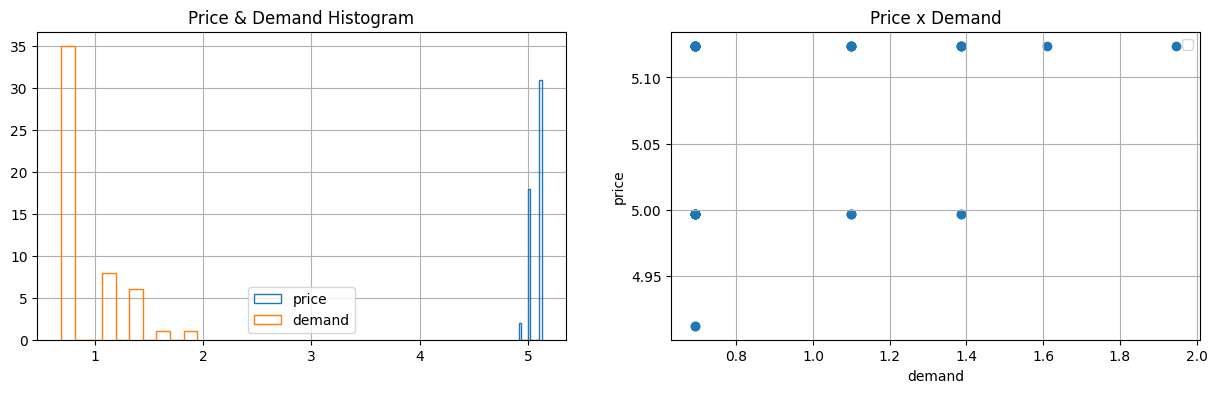

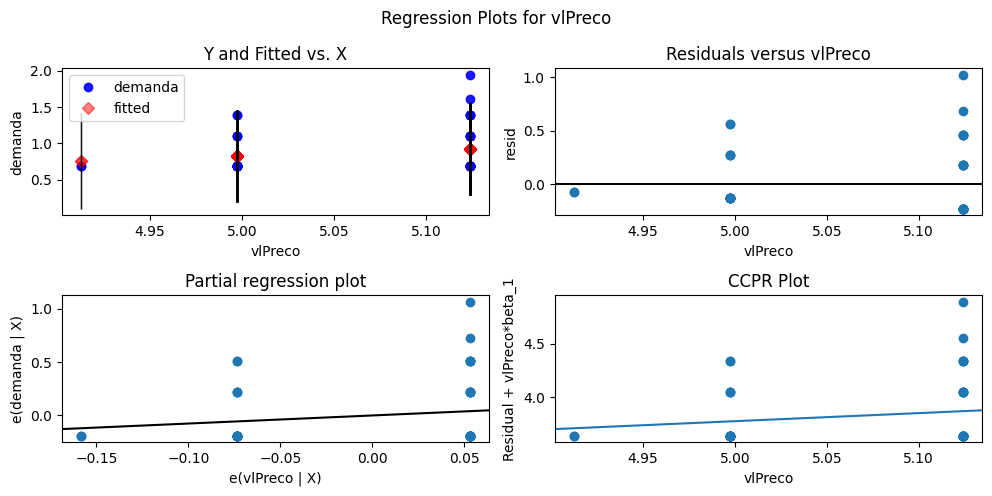

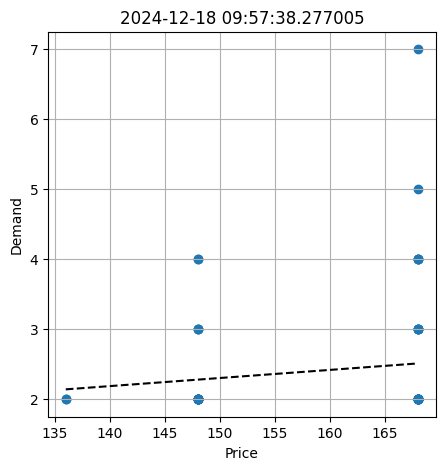

In [63]:
demand = np.log1p(df.loc[df["idProduto"] == "165f86fe8b799a708a20ee4ba125c289", "demanda"])
price  = np.log1p(df.loc[df["idProduto"] == "165f86fe8b799a708a20ee4ba125c289", "vlPreco"])

lr, fig = fit_ols(
    demand,
    price
)

##### Product: 461f43be3bdf8844e65b62d9ac2c7a5a

For product "461f43be3bdf8844e65b62d9ac2c7a5a", if the price increase 10%, the demand decrease by 4.7 %

                            OLS Regression Results                            
Dep. Variable:                demanda   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.958
Date:                Wed, 18 Dec 2024   Prob (F-statistic):              0.167
Time:                        09:58:22   Log-Likelihood:                 5.4948
No. Observations:                  56   AIC:                            -6.990
Df Residuals:                      54   BIC:                            -2.939
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2031      1.708      1.875      0.0

/tmp/ipykernel_7888/3491391798.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axi.legend()


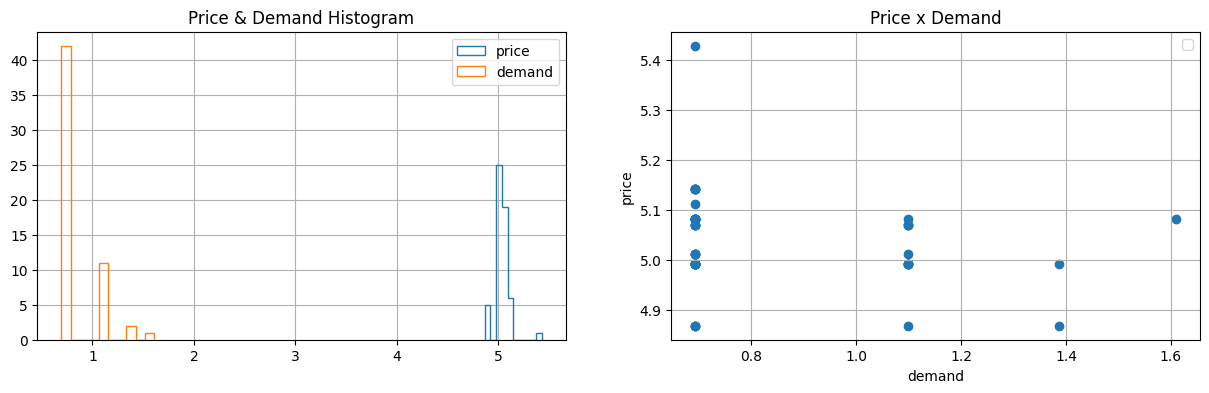

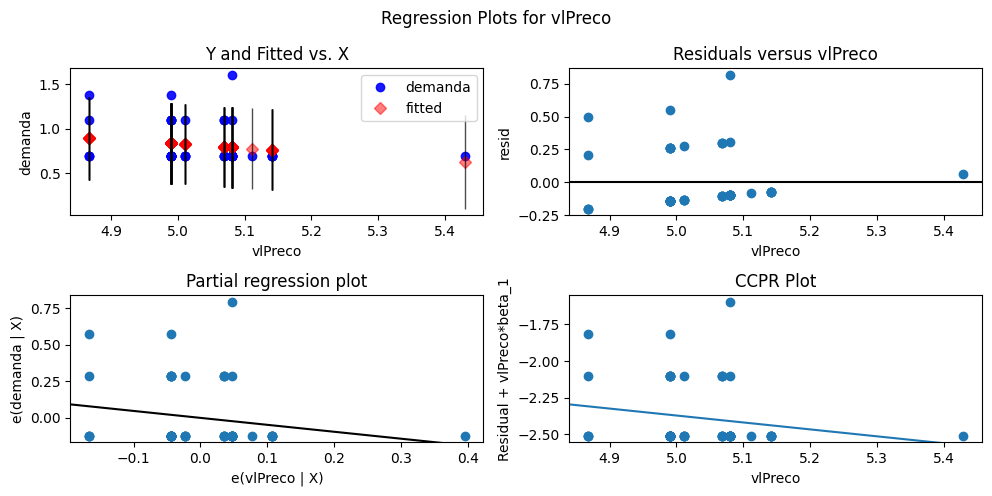

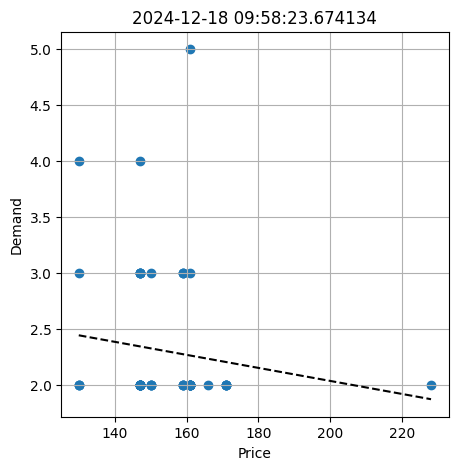

In [64]:
demand = np.log1p(df.loc[df["idProduto"] == "461f43be3bdf8844e65b62d9ac2c7a5a", "demanda"])
price  = np.log1p(df.loc[df["idProduto"] == "461f43be3bdf8844e65b62d9ac2c7a5a", "vlPreco"])

lr, fig = fit_ols(
    demand,
    price
)

#### Mlflow

Objective with Mlflow: I need to re-train the Price Elasticity every week and i need to track the evolution of Elasticity and Price X Demand for this three principal products:

- 8c591ab0ca519558779df02023177f44;
- 165f86fe8b799a708a20ee4ba125c289;
- 461f43be3bdf8844e65b62d9ac2c7a5a;

The main ideia is to have a machine learning governance and price elasticity versioning for compare price x demand in past and present, the assumption is, if i increase the price WoW (Week over week), the demand can change and is very important to business keep track of this changes weekly.

##### Simulating for Next 2 Weeks.

Assumption: Today is "2018-01-01", i will first train the Elasticity Regression with OLS for this three products.

For the next three weeks in weekly basis the business need to re-train the price elasticity and compare the results between the weeks. 

Today (2018-01-01) i have all past observations in a database, such as Data Warehouse or Lakehouse, does not matter, the key point is, for the next 7 days up to 2018-01-08 the products can be purchased again and in date 2018-01-08 a new price elasticity model need to be trained for capture new cliets pattern and for compare with last week.

In [120]:
for week in [0, 1, 2]:
    train_date = (datetime(2018, 1, 1) + timedelta(weeks=week)).strftime("%Y-%m-%d")

    print(f"Train Date {train_date} for {week} week.")

Train Date 2018-01-01 for 0 week.
Train Date 2018-01-08 for 1 week.
Train Date 2018-01-15 for 2 week.


Now its time to check the variation of Demand x Price and compute descriptive statistics with that.

Is possible to check some of the descriptive statistics change over time because cliets is purchasing the products and a new price elasticity need to be generated for every week.

In [84]:
products = [
    "8c591ab0ca519558779df02023177f44",
    "165f86fe8b799a708a20ee4ba125c289",
    "461f43be3bdf8844e65b62d9ac2c7a5a"
]

In [119]:
for week in [0, 1, 2]:
    train_date = (datetime(2018, 1, 1) + timedelta(weeks=week)).strftime("%Y-%m-%d")

    for product in products:
        df = read_data(
            date=train_date,
            product_id=product
        )

        print(f"Product Id: {product}")
        print(f"Last Purchase Date: {df['dtPedido'].max()}, Week Date: {train_date}")
        display(df.describe().T)
    
    print("=" * 50)
    print("\n\n")


Product Id: 8c591ab0ca519558779df02023177f44
Last Purchase Date: 2017-12-10, Week Date: 2018-01-01


,count,mean,std,min,25%,50%,75%,max
vlPreco,50.0,97.251998,9.639448,89.0,89.989998,94.494999,99.989998,120.0
demanda,50.0,1.540000,0.973317,1.0,1.000000,1.000000,2.000000,6.0


Product Id: 165f86fe8b799a708a20ee4ba125c289
Last Purchase Date: 2017-12-31, Week Date: 2018-01-01


,count,mean,std,min,25%,50%,75%,max
vlPreco,45.0,157.567783,10.926384,134.990005,146.990005,166.990005,166.990005,166.990005
demanda,45.0,1.555556,1.034750,1.000000,1.000000,1.000000,2.000000,6.000000


Product Id: 461f43be3bdf8844e65b62d9ac2c7a5a
Last Purchase Date: 2017-12-19, Week Date: 2018-01-01


,count,mean,std,min,25%,50%,75%,max
vlPreco,56.0,153.145177,14.603921,129.0,146.0,149.0,159.899994,227.0
demanda,56.0,1.321429,0.635528,1.0,1.0,1.0,1.250000,4.0





Product Id: 8c591ab0ca519558779df02023177f44
Last Purchase Date: 2018-01-05, Week Date: 2018-01-08


,count,mean,std,min,25%,50%,75%,max
vlPreco,52.0,98.895768,12.575732,89.0,89.989998,99.0,99.989998,139.990005
demanda,52.0,1.519231,0.959787,1.0,1.000000,1.0,2.000000,6.000000


Product Id: 165f86fe8b799a708a20ee4ba125c289
Last Purchase Date: 2018-01-07, Week Date: 2018-01-08


,count,mean,std,min,25%,50%,75%,max
vlPreco,51.0,158.67628,10.698580,134.990005,146.990005,166.990005,166.990005,166.990005
demanda,51.0,1.54902,1.006255,1.000000,1.000000,1.000000,2.000000,6.000000


Product Id: 461f43be3bdf8844e65b62d9ac2c7a5a
Last Purchase Date: 2017-12-19, Week Date: 2018-01-08


,count,mean,std,min,25%,50%,75%,max
vlPreco,56.0,153.145177,14.603921,129.0,146.0,149.0,159.899994,227.0
demanda,56.0,1.321429,0.635528,1.0,1.0,1.0,1.250000,4.0





Product Id: 8c591ab0ca519558779df02023177f44
Last Purchase Date: 2018-01-05, Week Date: 2018-01-15


,count,mean,std,min,25%,50%,75%,max
vlPreco,52.0,98.895768,12.575732,89.0,89.989998,99.0,99.989998,139.990005
demanda,52.0,1.519231,0.959787,1.0,1.000000,1.0,2.000000,6.000000


Product Id: 165f86fe8b799a708a20ee4ba125c289
Last Purchase Date: 2018-01-13, Week Date: 2018-01-15


,count,mean,std,min,25%,50%,75%,max
vlPreco,54.0,159.138154,10.567675,134.990005,146.990005,166.990005,166.990005,166.990005
demanda,54.0,1.537037,0.985038,1.000000,1.000000,1.000000,2.000000,6.000000


Product Id: 461f43be3bdf8844e65b62d9ac2c7a5a
Last Purchase Date: 2017-12-19, Week Date: 2018-01-15


,count,mean,std,min,25%,50%,75%,max
vlPreco,56.0,153.145177,14.603921,129.0,146.0,149.0,159.899994,227.0
demanda,56.0,1.321429,0.635528,1.0,1.0,1.0,1.250000,4.0


##### Fit OLS Estimators for Product: 165f86fe8b799a708a20ee4ba125c289

In [143]:
for week in [0, 1, 2]:
    train_date = (datetime(2018, 1, 1) + timedelta(weeks=week)).strftime("%Y-%m-%d")
    df = read_data(
        date=train_date,
        product_id="165f86fe8b799a708a20ee4ba125c289"
    )

    lr = fit_ols(np.log1p(df["demanda"]), np.log1p(df["vlPreco"]), extra_plots=False, print_summary=False)
    const, slope = lr.params

    print("=" * 50)
    print(f"Train Week: {train_date}")
    print(f"Percentage: {slope:.4f}, P-Value: {lr.f_pvalue:.4f}, R2: {lr.rsquared:.4f}")

Train Week: 2018-01-01
Percentage: 0.8299, P-Value: 0.2248, R2: 0.0341
Train Week: 2018-01-08
Percentage: 0.7554, P-Value: 0.2414, R2: 0.0279
Train Week: 2018-01-15
Percentage: 0.6982, P-Value: 0.2628, R2: 0.0240


##### Mlflow Experiment & Tracking

I will track all week in a new Mlflow experiment to control parameters, models, versions and more. The structure of the models is in a tree below:


```md
Experiment: PriceElasticity
├── Top Run: Ols[ProductId1]
│   ├── Nesting: 20240815
│   ├── Nesting: 20240808
│   └── Nesting: 20240801
...
```

In [ ]:
import mlflow

mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_SERVER"))
print(f"Tracking Server URI: '{mlflow.get_tracking_uri()}'")

experiment_name = "OlistPriceElasticity"

try:
    experiment_id = mlflow.get_experiment_by_name(name=experiment_name).experiment_id
except:
    experiment_id = mlflow.create_experiment(name=experiment_name)

print(f"Experiment Id: {experiment_id}")

In [3]:
products = [
    "8c591ab0ca519558779df02023177f44",
    "165f86fe8b799a708a20ee4ba125c289",
    "461f43be3bdf8844e65b62d9ac2c7a5a"
]

With this very simple approach of name [ols-DATE-PRODUCT] is possible in Mlflow Web server (UI) compare multiple models of the same product id and other possible validations. 

In [ ]:
for product_id in products:

    for week in [0, 1, 2]:
        train_date = (datetime(2018, 1, 1) + timedelta(weeks=week)).strftime("%Y-%m-%d")
        
        # Load Data
        df = read_data(date=train_date, product_id=product_id)

        with mlflow.start_run(
            experiment_id=experiment_id,
            run_name=f"ols-{train_date}-{product_id}"
        ) as active_run:
            
            # Fit Model
            lr, fig = fit_ols(
                np.log1p(df["demanda"]),
                np.log1p(df["vlPreco"]),
                print_summary=False,
                extra_plots=False,
                return_demand_price_fig=True
            );
            
            mlflow.log_params({
                "train_date": train_date,
                "product_id": product_id
            })
            
            #mlflow.log_input(mlflow.data.from_pandas(df.head(1)), context="sample_raw_data")
            mlflow.log_metrics(lr.params.to_dict())
            mlflow.log_figure(fig, "figs/demand_x_price.png")
            mlflow.sklearn.log_model(
                lr,
                "models/ols",
            #    signature=model_signature
            );


For production perspective i need to fetch the most recent run for every product and most accurate (recent) train_filter_date.

But if the Data Scientist re-train a model using a past date ?
- Assumption: The past dates will never ben update.

In [14]:
df_runs = mlflow.search_runs(
    experiment_ids=[experiment_id]
)

df_runs[["run_id", "params.train_date", "params.product_id", "metrics.vlpreco", "metrics.const"]]

,run_id,params.train_date,params.product_id,metrics.vlpreco,metrics.const
0,e22338d0b8e94e8d9fb0ecf47d8fff3c,2018-01-28,461f43be3bdf8844e65b62d9ac2c7a5a,-0.475132,3.205834
1,99d72dba4d9b492ba1849802daa6efb4,2018-01-28,165f86fe8b799a708a20ee4ba125c289,0.698204,-2.664657
2,598a203d5c5042f89d177e29e6ce5472,2018-01-28,8c591ab0ca519558779df02023177f44,-0.870342,4.880133
3,529d4080d8ce4d789d48eb8137650083,2018-01-21,461f43be3bdf8844e65b62d9ac2c7a5a,-0.474620,3.203089
4,89786c950ab849e6a34c17f2e7897b3a,2018-01-21,165f86fe8b799a708a20ee4ba125c289,0.698204,-2.664657
5,1cac23e9856c476eb18906a0e65856a8,2018-01-21,8c591ab0ca519558779df02023177f44,-0.956792,5.271896
6,e9249abcecc347598d06db1b5bc84dbf,2018-01-14,461f43be3bdf8844e65b62d9ac2c7a5a,-0.474620,3.203089
7,3dcfb837a5fa410ca53a93ab2ab0234d,2018-01-14,165f86fe8b799a708a20ee4ba125c289,0.698204,-2.664657
8,c72a62f94e4f44eb8d9a0ba587bfa51f,2018-01-14,8c591ab0ca519558779df02023177f44,-0.962554,5.298011
9,24b9ab2b42344ea5872e82c158fcccd9,2018-01-07,461f43be3bdf8844e65b62d9ac2c7a5a,-0.474620,3.203089


In [94]:
df_recent_train_product = df_runs[["run_id", "params.train_date", "params.product_id"]].groupby(
    "params.product_id"
).agg(
    last_date=("params.train_date", "max")
).reset_index()

df_recent_train_product.columns = ["params.product_id", "params.train_date"]

df_runs.merge(
    df_recent_train_product,
    how="inner",
    on=["params.product_id", "params.train_date"]
)[["run_id", "params.train_date", "metrics.vlPreco", "metrics.const", "tags.mlflow.runName"]]

,run_id,params.train_date,metrics.vlPreco,metrics.const,tags.mlflow.runName
0,1cb7370b27fb4b1b8e60eaba9990b066,2018-01-15,-0.474620,3.203089,ols-2018-01-15-461f43be3bdf8844e65b62d9ac2c7a5a
1,49d1f6896b9e462980a9501d3c9e479c,2018-01-15,0.698204,-2.664657,ols-2018-01-15-165f86fe8b799a708a20ee4ba125c289
2,15398b5b8c3d4d4b8f6ff319993f88e0,2018-01-15,-0.962554,5.298010,ols-2018-01-15-8c591ab0ca519558779df02023177f44


Making Predictions!

In [47]:
logged_model = "runs:/1cb7370b27fb4b1b8e60eaba9990b066/models/ols"
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [48]:
np.expm1(loaded_model.predict([[1, np.log1p(140)]]))

array([1.34974381])

In [49]:
# y = a * x + b

np.expm1(np.log(140) * -0.474620 + 3.203089	)

1.3577002494990664